# Dog Breeds

In [1]:
# import useful packages
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.callbacks import History, TensorBoard
from keras import applications

import tensorflow as tf

import sys, os, subprocess
from shutil import copyfile
import shutil

Using TensorFlow backend.


In [2]:
# callbacks
history = History()
tb = TensorBoard()

In [69]:
labels_df = pd.read_csv('/mnt/DataDisk/jodahr/data/Dogs/labels.csv')

In [70]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
id       10222 non-null object
breed    10222 non-null object
dtypes: object(2)
memory usage: 159.8+ KB


In [71]:
top20 = labels_df.breed.value_counts().index.tolist()[:20]

In [5]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [16]:
labels_df_top20 = labels_df[labels_df.breed.isin(top20)]

In [22]:
labels_df_top20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2184 entries, 8 to 10220
Data columns (total 2 columns):
id       2184 non-null object
breed    2184 non-null object
dtypes: object(2)
memory usage: 51.2+ KB


## Prepare Training Data

In [13]:
# make subdirs for dog breeds
for breed in top20:
    os.makedirs('/mnt/DataDisk/jodahr/data/Dogs/top20/training/' + breed, exist_ok=True)
    os.makedirs('/mnt/DataDisk/jodahr/data/Dogs/top20/validation/' + breed, exist_ok=True)

In [17]:
# image path
path = '/mnt/DataDisk/jodahr/data/Dogs/train/'

In [19]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(labels_df_top20, test_size=0.2)

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1747 entries, 3989 to 6335
Data columns (total 2 columns):
id       1747 non-null object
breed    1747 non-null object
dtypes: object(2)
memory usage: 40.9+ KB


In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437 entries, 6433 to 8415
Data columns (total 2 columns):
id       437 non-null object
breed    437 non-null object
dtypes: object(2)
memory usage: 10.2+ KB


In [20]:
for index, row in train.iterrows():
    filename = row['id'] + '.jpg'
    src = path + filename
    target = '/mnt/DataDisk/jodahr/data/Dogs/top20/training/' + row['breed']
    shutil.copy(src=src, dst=target)

In [21]:
for index, row in test.iterrows():
    filename = row['id'] + '.jpg'
    src = path + filename
    target = '/mnt/DataDisk/jodahr/data/Dogs/top20/validation/' + row['breed']
    shutil.copy(src=src, dst=target)

## Keras Model

In [40]:
# dimensions of our images.
img_width, img_height = 250, 250

train_data_dir = '/mnt/DataDisk/jodahr/data/Dogs/top20/training/'
validation_data_dir = '/mnt/DataDisk/jodahr/data/Dogs/top20/validation/'

nb_train_samples = 1747
nb_validation_samples = 437
epochs = 30
batch_size = 64

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [51]:
base_model = applications.VGG16(include_top=False, input_shape=input_shape)

In [52]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 62, 128)       0         
__________

In [53]:
for layer in base_model.layers[:]:
    layer.trainable = False

In [54]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 62, 128)       0         
__________

In [55]:
# model topology
top_model = Sequential()

top_model.add(Conv2D(128, (2, 2), input_shape=base_model.output_shape[1:]))
top_model.add(Activation('relu'))
top_model.add(MaxPooling2D(pool_size=(2, 2)))

#top_model.add(Conv2D(32, (2, 2)))
#top_model.add(Activation('relu'))
#top_model.add(MaxPooling2D(pool_size=(2, 2)))

top_model.add(Flatten())
top_model.add(Dense(128))
top_model.add(Activation('relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(20))
top_model.add(Activation('softmax'))



In [56]:
from keras import Model
from keras import metrics

model = Model(inputs= base_model.input, outputs= top_model(base_model.output))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[metrics.categorical_accuracy])

In [57]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [58]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 1747 images belonging to 20 classes.
Found 437 images belonging to 20 classes.


In [59]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 62, 128)       0         
__________

In [60]:
with tf.device('/gpu:0'):
    model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks = [history, tb])

Epoch 1/30
27/27 [==============================] - 23s 838ms/step - loss: 3.0276 - categorical_accuracy: 0.0758 - val_loss: 2.9193 - val_categorical_accuracy: 0.0859
Epoch 2/30
27/27 [==============================] - 22s 814ms/step - loss: 2.8700 - categorical_accuracy: 0.1082 - val_loss: 2.7676 - val_categorical_accuracy: 0.1120
Epoch 3/30
27/27 [==============================] - 22s 813ms/step - loss: 2.6995 - categorical_accuracy: 0.1521 - val_loss: 2.5295 - val_categorical_accuracy: 0.2240
Epoch 4/30
27/27 [==============================] - 22s 814ms/step - loss: 2.5642 - categorical_accuracy: 0.1801 - val_loss: 2.3296 - val_categorical_accuracy: 0.3021
Epoch 5/30
27/27 [==============================] - 22s 814ms/step - loss: 2.3464 - categorical_accuracy: 0.2487 - val_loss: 2.0269 - val_categorical_accuracy: 0.3568
Epoch 6/30
27/27 [==============================] - 22s 812ms/step - loss: 2.1849 - categorical_accuracy: 0.3070 - val_loss: 1.8591 - val_categorical_accuracy: 0.393

In [61]:
model.save_weights('my_model_weights_top20.h5')

In [83]:
## custom batch generator
test_path = '/mnt/DataDisk/jodahr/data/Dogs/top20/validation'

In [48]:
import cv2

In [159]:
# not very elegant, but works
def customGenerator(path, batch_size=32, target_size=(250,250), add_names=False):
    '''Generator wich returns batches of img arrays. Alternatively you can add the filenames.'''
    file_names = os.listdir(path)  # list of filenames
    chunks = [file_names[x:x+batch_size] for x in range(0, len(file_names), batch_size)]  # divided into chunks
    
    for chunk in chunks:
        full_names = [path + '/' + file_name for file_name in chunk]  # create full filenames
        img_batch = [load_img(full_name, target_size=target_size) for full_name in full_names]  # load image batches
        arr_batch = np.empty(shape=(1,target_size[0],target_size[1],3))  # empty multidimensional numpy array
        #arr_batch = []
        # rescale arrays and combine them
        for element in img_batch:
            img_arr = np.expand_dims(img_to_array(element)/255., axis=0)
            arr_batch = np.concatenate((arr_batch, img_arr), axis=0)
        # yield
        if add_names==False:
            yield arr_batch[1:,:,:,:]
        else:
            yield (arr_batch[1:,:,:,:], chunk)

In [160]:
pathes = [test_path + '/' + breed  for breed in top20]

In [161]:
pathes

['/mnt/DataDisk/jodahr/data/Dogs/top20/validation/scottish_deerhound',
 '/mnt/DataDisk/jodahr/data/Dogs/top20/validation/maltese_dog',
 '/mnt/DataDisk/jodahr/data/Dogs/top20/validation/afghan_hound',
 '/mnt/DataDisk/jodahr/data/Dogs/top20/validation/entlebucher',
 '/mnt/DataDisk/jodahr/data/Dogs/top20/validation/bernese_mountain_dog',
 '/mnt/DataDisk/jodahr/data/Dogs/top20/validation/shih-tzu',
 '/mnt/DataDisk/jodahr/data/Dogs/top20/validation/great_pyrenees',
 '/mnt/DataDisk/jodahr/data/Dogs/top20/validation/pomeranian',
 '/mnt/DataDisk/jodahr/data/Dogs/top20/validation/basenji',
 '/mnt/DataDisk/jodahr/data/Dogs/top20/validation/samoyed',
 '/mnt/DataDisk/jodahr/data/Dogs/top20/validation/airedale',
 '/mnt/DataDisk/jodahr/data/Dogs/top20/validation/tibetan_terrier',
 '/mnt/DataDisk/jodahr/data/Dogs/top20/validation/cairn',
 '/mnt/DataDisk/jodahr/data/Dogs/top20/validation/leonberg',
 '/mnt/DataDisk/jodahr/data/Dogs/top20/validation/beagle',
 '/mnt/DataDisk/jodahr/data/Dogs/top20/valida

In [162]:
customGenerator(pathes[0], add_names=True)

<generator object customGenerator at 0x7f9e631df5c8>

In [170]:
gens = [customGenerator(p, add_names=True) for p in pathes]

In [171]:
class_names = [cls for cls in train_generator.class_indices]

In [172]:
class_names

['afghan_hound',
 'airedale',
 'australian_terrier',
 'basenji',
 'beagle',
 'bernese_mountain_dog',
 'blenheim_spaniel',
 'cairn',
 'entlebucher',
 'great_pyrenees',
 'irish_wolfhound',
 'japanese_spaniel',
 'leonberg',
 'maltese_dog',
 'miniature_pinscher',
 'pomeranian',
 'samoyed',
 'scottish_deerhound',
 'shih-tzu',
 'tibetan_terrier']

In [173]:
def get_results(my_generator_tuple, model, class_names):
    result = pd.DataFrame()
    for element in my_generator_tuple:
        predictions = model.predict(element[0])
        names = element[1]
        temp = pd.DataFrame({'idx': predictions.argmax(axis=1),
                             'score': predictions.max(axis=1),
                             'filenames': names})
        temp['class_name'] = temp['idx'].apply(lambda x: class_names[x])
        result = pd.concat([result,temp])
    return result
    

In [174]:
df = pd.DataFrame()
for gen in gens:
    temp = get_results(gen, model, class_names)
    df = pd.concat([df,temp])

In [180]:
df.sort_values('score', ascending=False).head(10)

,filenames,idx,score,class_name
16,f09b337e8e9424b208854b361f28e39e.jpg,4,0.999993,beagle
26,dc07c140b26ba8f2c75770f00229270b.jpg,11,0.999985,japanese_spaniel
8,69f0ad7b0b8ca686c1636067726a05e2.jpg,8,0.999979,entlebucher
9,9672be8c46f615dd8afa075e93960e90.jpg,0,0.999978,afghan_hound
17,f0b08d4f04e66b73526313b7cf0a6b08.jpg,4,0.999973,beagle
23,cf006bb3f31c015f513071e9067f8ee0.jpg,11,0.999964,japanese_spaniel
18,8174c92381421de8ab5cfb54366a086e.jpg,15,0.999884,pomeranian
1,071652f5f5d0bf00983c075e96ad725f.jpg,11,0.999853,japanese_spaniel
1,0779e164a5bed1119e36e622107c6a77.jpg,15,0.999843,pomeranian
8,67a641f9c7746193b5912198dbc4ad07.jpg,4,0.999775,beagle


In [184]:
import glob
validation_data_dir

'/mnt/DataDisk/jodahr/data/Dogs/top20/validation/'

In [190]:
from matplotlib import pyplot as plt

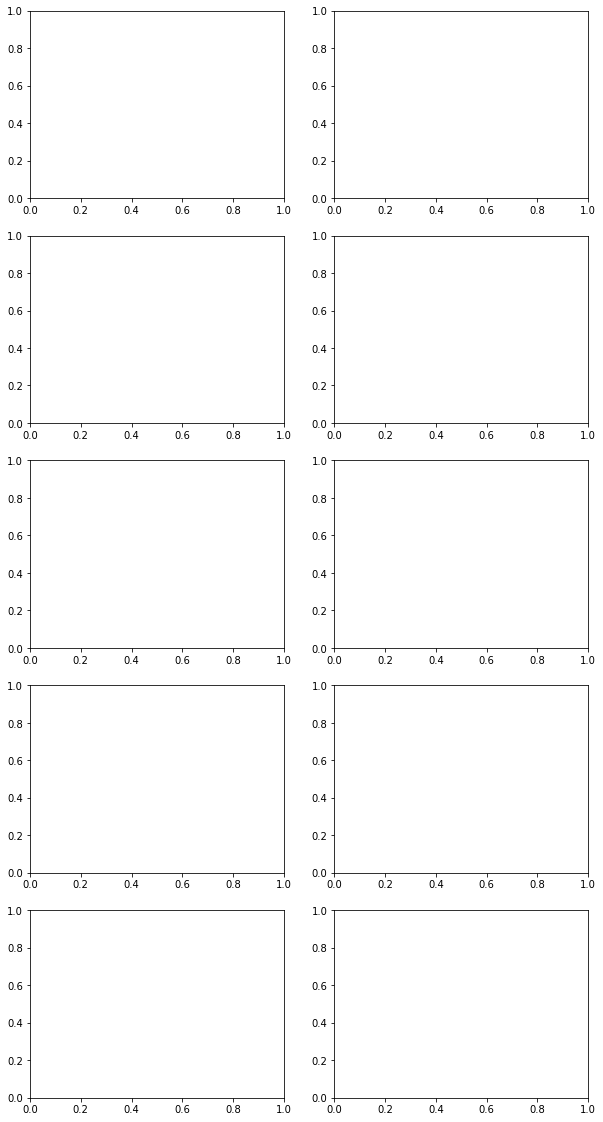

In [234]:
fig, ax = plt.subplots(ncols=2, nrows=5,figsize=(10,20))
fig

In [235]:
x,y = 0,0
for idx, row in df.sort_values('score', ascending=False).head(10).iterrows():
    file_path = validation_data_dir + row['class_name'] + '/' + row['filenames']
    img = load_img(file_path, target_size=(224,224))
    ax[x,y].imshow(img)
    ax[x,y].text(10, 180, '%s (%.2f)' % (row['class_name'] , row['score']), color='w', backgroundcolor='k', alpha=0.8)
#    ax.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    if x < 4:
        x +=1
    else:
        x=0
        y+=1
    print(x,y)
    

1 0
2 0
3 0
4 0
0 1
1 1
2 1
3 1
4 1
0 2


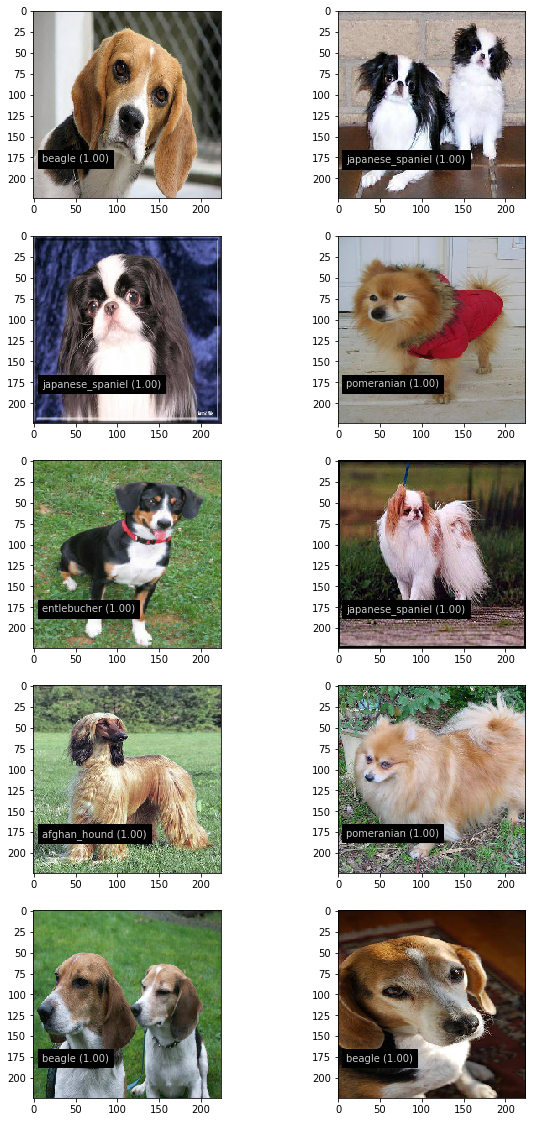

In [236]:
fig

In [237]:
from vis import visualization

In [240]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 62, 128)       0         
__________

In [243]:
files = []
for idx, row in df.sort_values('score', ascending=False).head(10).iterrows():
    file_path = validation_data_dir + row['class_name'] + '/' + row['filenames']
    files.append(file_path)

In [284]:
x_im = load_img(files[0], target_size=(250,250))
x = img_to_array(x_im)/255.

In [280]:
hm = visualization.visualize_cam(model, layer_idx=18, filter_indices=[4], seed_input=x)

In [363]:
hm = visualization.visualize_cam(model, layer_idx=18, filter_indices=[4], seed_input=x)

In [364]:
import seaborn as sns

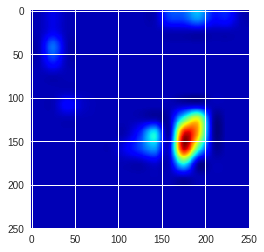

In [365]:
%matplotlib inline
plt.imshow(hm)

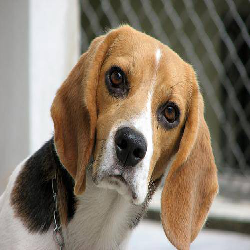

In [366]:
x_im

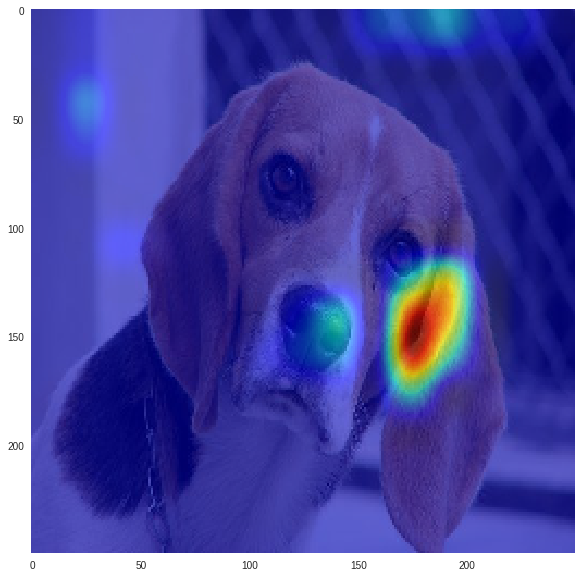

In [367]:
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(False)
ax.imshow(x_im)
ax.imshow(hm, alpha=0.6)

In [279]:
class_names

['afghan_hound',
 'airedale',
 'australian_terrier',
 'basenji',
 'beagle',
 'bernese_mountain_dog',
 'blenheim_spaniel',
 'cairn',
 'entlebucher',
 'great_pyrenees',
 'irish_wolfhound',
 'japanese_spaniel',
 'leonberg',
 'maltese_dog',
 'miniature_pinscher',
 'pomeranian',
 'samoyed',
 'scottish_deerhound',
 'shih-tzu',
 'tibetan_terrier']

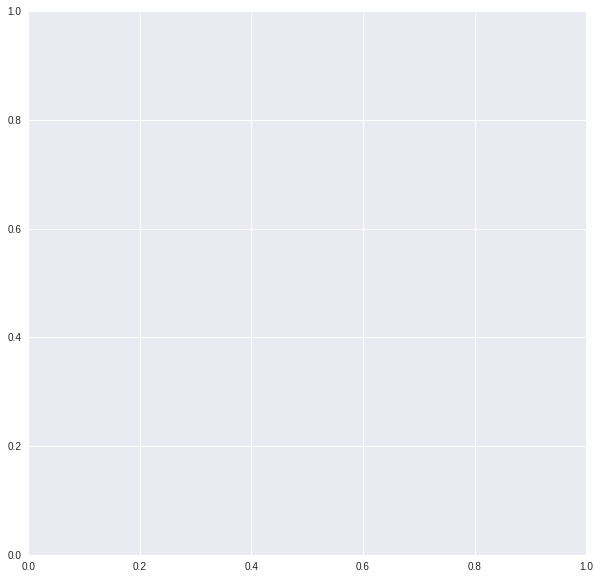

In [369]:
fig, ax = plt.subplots(figsize=(10,10))
def cam_image(file_path, layer, filter_idx, ax, alpha=0.6):
    x_im = load_img(file_path, target_size=(250,250))
    x = img_to_array(x_im)/255.
    hm = visualization.visualize_cam(model, layer_idx=layer, filter_indices=filter_idx, seed_input=x)
    ax.grid(False)
    ax.imshow(x_im)
    ax.imshow(hm, alpha=0.6)

In [373]:
file_path

'/mnt/DataDisk/jodahr/data/Dogs/top20/validation/beagle/67a641f9c7746193b5912198dbc4ad07.jpg'

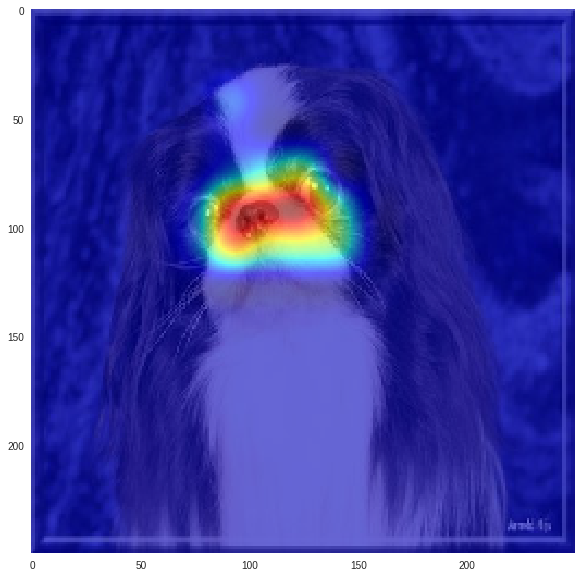

In [376]:
fig, ax = plt.subplots(figsize=(10,10))
cam_image(files[1],18,[11],ax)

In [377]:
model.layers[-1].activation='linear'

In [378]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 62, 128)       0         
__________

In [383]:
model.predict(np.expand_dims(x, axis=0)).sum()

1.0000001

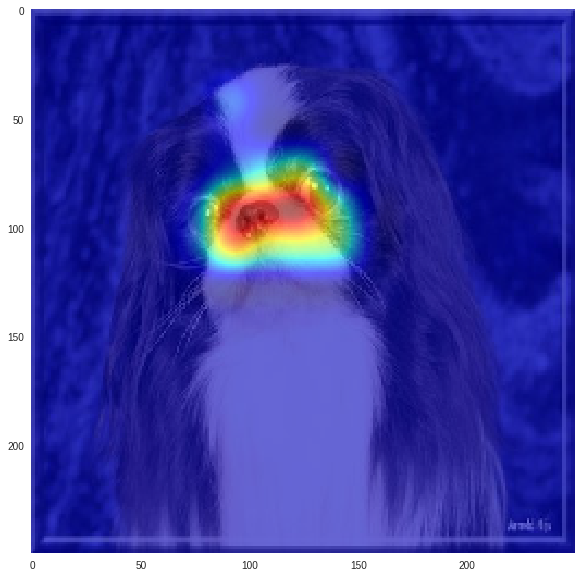

In [380]:
fig, ax = plt.subplots(figsize=(10,10))
cam_image(files[1],18,[11],ax)

In [389]:
from keras import activations, utils
from vis import utils

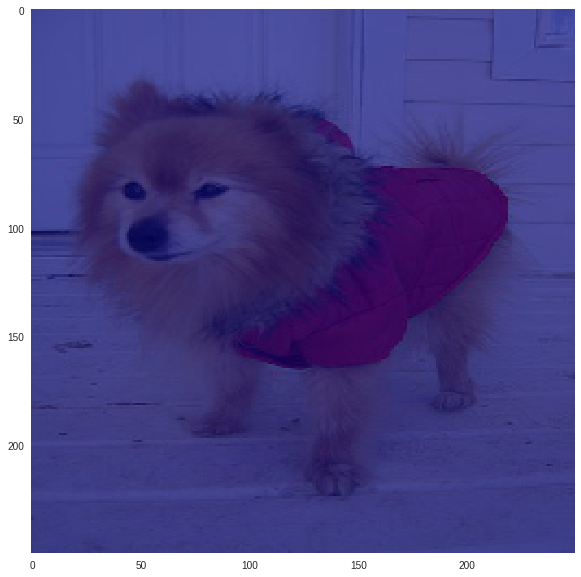

In [417]:
fig, ax = plt.subplots(figsize=(10,10))
cam_image(files[6],18,[11],ax)

## understanding layers

In [419]:
dog = files[0]

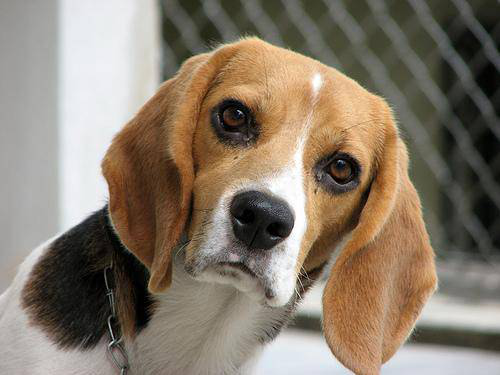

In [421]:
load_img(dog)

In [423]:
x = img_to_array(load_img(dog))

In [425]:
x.shape

(375, 500, 3)

In [429]:
img_width= 375
img_height = 500

In [430]:
# to adjust for the backend (here tensorflow)
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [469]:
conv1 = Sequential()
conv1.add(Convolution2D(3, (3, 3), input_shape=input_shape))
conv1.add(Activation('relu'))

In [470]:
x_pred = conv1.predict(np.expand_dims(x, axis=0))

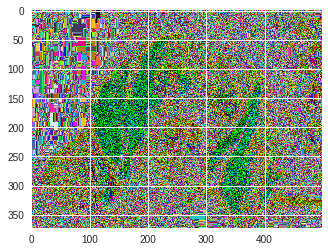

In [471]:
plt.imshow(x_pred[0,:,:,:])

In [465]:
from keras.layers import Convolution2D

In [472]:
conv1 = Sequential()
conv1.add(Convolution2D(3, (2, 2), input_shape=input_shape))
conv1.add(Activation('relu'))

In [473]:
x_pred = conv1.predict(np.expand_dims(x, axis=0))

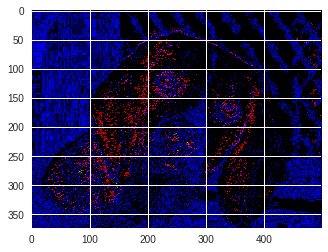

In [474]:
plt.imshow(x_pred[0,:,:,:])

In [484]:
conv1 = Sequential()
conv1.add(Convolution2D(3, (4, 4), input_shape=input_shape))
conv1.add(Activation('relu'))

In [485]:
x_pred = conv1.predict(np.expand_dims(x, axis=0))

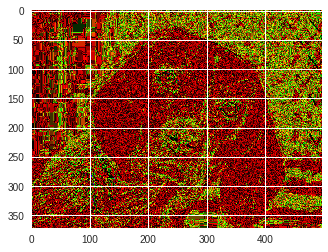

In [486]:
plt.imshow(x_pred[0,:,:,:])